In [1]:
import unittest
import numpy as np
import treecorr
import healpy as hp
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time 
import os
import coord
from numba import jit, njit


sys.path.insert(1,'../src/')

from CosmoFuse.correlations import Correlation_CPU
from CosmoFuse.utils import pixel2RaDec

In [2]:
nside = 512
radius_patch = 90/60
radius_filter = 5 * radius_patch
theta_Q = np.radians(radius_filter)
nbins = 10
n_patches = 992
des_map = hp.read_map("./data/DESY3_Mask.fits")


map_inds = np.where(des_map!=0)[0]
phi_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_phi.dat")[:n_patches]
theta_center = np.loadtxt("/e/ocean1/users/dgebauer/patch_centers/patch_center_original_theta.dat")[:n_patches]


npix = hp.nside2npix(nside)

mintheta = 20
maxtheta = 170

mintheta = mintheta/60/180*np.pi
maxtheta = maxtheta/60/180*np.pi

shear_maps = np.load("./data/shear_maps.npy")        

min_theta = 20
max_theta = 170

w = np.ones_like(shear_maps[0,0])

binedges=np.geomspace(min_theta,max_theta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))

binedges=np.geomspace(mintheta,maxtheta,nbins+1)
bincenters=np.exp(np.diff(np.log(binedges))/2+np.log(binedges[:-1]))/np.pi*180*60

In [3]:
%%time

def get_pairs_coord(nside, patch_inds, ra, dec, binedges, nbins):
    all_inds, exp2theta1_temp, exp2theta2_temp = [], [], []
    cos_vartheta = np.cos(np.subtract.outer(ra, ra))*np.multiply.outer(np.cos(dec),np.cos(dec)) + np.multiply.outer(np.sin(dec),np.sin(dec))
    dist = np.arccos(np.triu(cos_vartheta, k=1))    
    #dist = np.arccos(cos_vartheta)    
    
    north_pole = coord.CelestialCoord(0*coord.radians, 90*coord.degrees)

    for i in range(nbins):
        inds = np.where((dist > binedges[i]) & (dist < binedges[i+1]))
        pair_inds = np.array([patch_inds[inds[0]], patch_inds[inds[1]]])
        ra_pairs1 = ra[inds[0]]
        dec_pairs1 = dec[inds[0]]
        ra_pairs2 = ra[inds[1]]
        dec_pairs2 = dec[inds[1]]
        
        c1 = [coord.CelestialCoord(r*coord.radians, d*coord.radians) for (r,d) in zip(ra_pairs1, dec_pairs1)]
        c2 = [coord.CelestialCoord(r*coord.radians, d*coord.radians) for (r,d) in zip(ra_pairs2, dec_pairs2)]
        
        all_inds.append(pair_inds)
        
        for j, _ in enumerate(ra_pairs1):
            theta1 = 90*coord.degrees - c1[j].angleBetween(north_pole, c2[j])
            theta2 = 90*coord.degrees - c2[j].angleBetween(north_pole, c1[j])
            exp2theta1 = np.cos(2*theta1) + 1j * np.sin(2*theta1)
            exp2theta2 = np.cos(2*theta2) + 1j * np.sin(2*theta2)

            exp2theta1_temp.append(exp2theta1)
            exp2theta2_temp.append(exp2theta2)
    
    exp2theta = np.array([exp2theta1_temp, exp2theta2_temp])
    return all_inds, exp2theta, dist

pair_inds, pair_exp2theta, bins, dist = [], [], [], []

def get_pairs_coord_mult(i):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    ra, dec = pixel2RaDec(pix_inds, nside)
    inds, exp2theta, d = get_pairs_coord(nside, pix_inds, ra, dec, binedges, nbins)
    ninds = np.array([len(inds[i][0]) for i in range(nbins)])
    all_inds = np.zeros((2,ninds.sum()))
    for bin in range(nbins):
        all_inds[0,np.sum(ninds[:bin]):np.sum(ninds[:bin+1])] = inds[bin][0]
        all_inds[1,np.sum(ninds[:bin]):np.sum(ninds[:bin+1])] = inds[bin][1]
    
    return all_inds.astype(int), exp2theta, ninds, d

with Pool(100) as p:
    result = p.map(get_pairs_coord_mult, range(n_patches))

for i in range(n_patches):
    pair_inds.append(result[i][0])
    pair_exp2theta.append(result[i][1])
    bins.append(result[i][2])
    dist.append(result[i][3])
    
@njit(fastmath=False)
def xipm_jit_coord(inds, exp2theta, bin_inds, g11, g21, g12, g22):

    xip, xim = np.zeros(nbins, dtype='c8'), np.zeros(nbins, dtype='c8')
    
    g1 = ((-g11[inds[0]]) + 1j* g21[inds[0]]) * exp2theta[0] # minus in front of all g1?
    g2 = ((-g12[inds[1]]) + 1j*g22[inds[1]]) * exp2theta[1]

    bin_edges = np.append([0], np.cumsum(bin_inds))
    
    for bin in range(nbins):
        xip[bin] = np.sum(g1[bin_edges[bin]:bin_edges[bin+1]] * np.conjugate(g2[bin_edges[bin]:bin_edges[bin+1]]))/(bin_inds[bin])
        xim[bin] = np.sum(g1[bin_edges[bin]:bin_edges[bin+1]] * g2[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])
        

    return np.real(xip), np.real(xim)


def get_xipm_coord(i):
    xip, xim = xipm_jit_coord(pair_inds[i], pair_exp2theta[i], bins[i], shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1])
    return xip, xim


CPU times: user 19.4 s, sys: 21.6 s, total: 41 s
Wall time: 4min 2s


In [4]:
cos2phi_1, sin2phi_1, cos2phi_2, sin2phi_2 = [], [], [], []

for i in range(n_patches):
    cos2phi_1.append(np.real(pair_exp2theta[i][0]))
    sin2phi_1.append(np.imag(pair_exp2theta[i][0]))
    cos2phi_2.append(np.real(pair_exp2theta[i][1]))
    sin2phi_2.append(np.imag(pair_exp2theta[i][1]))
    
@njit(fastmath=False)
def xipm_new(inds, cos2phi_1, sin2phi_1, cos2phi_2, sin2phi_2, bin_inds, g11, g21, g12, g22, w1, w2, nbins):
    
    xip, xim = np.zeros(nbins, dtype=np.float32), np.zeros(nbins, dtype=np.float32)

    gt1 = - g11[inds[0]]*cos2phi_1 - g21[inds[0]]*sin2phi_1
    gx1 = - g11[inds[0]]*sin2phi_1 + g21[inds[0]]*cos2phi_1
    gt2 = - g12[inds[1]]*cos2phi_2 - g22[inds[1]]*sin2phi_2
    gx2 = - g12[inds[1]]*sin2phi_2 + g22[inds[1]]*sin2phi_2

    gt = gt1*gt2
    gx = gx1*gx2
    
    bin_edges = np.append([0], np.cumsum(bin_inds)).astype('int')
    
    for bin in range(nbins):
        xip[bin] = np.sum(gt[bin_edges[bin]:bin_edges[bin+1]]+gx[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])
        xim[bin] = np.sum(gt[bin_edges[bin]:bin_edges[bin+1]]-gx[bin_edges[bin]:bin_edges[bin+1]])/(bin_inds[bin])

    return xip, xim

def get_xipm_new(i):
        return xipm_new(pair_inds[i], cos2phi_1[i], sin2phi_1[i], cos2phi_2[i], sin2phi_2[i], bins[i], shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1], w, w, nbins)

In [5]:
xip_test, xim_test = [], []

for i in range(n_patches):
    a, b = get_xipm_new(i)
    xip_test.append(a)
    xim_test.append(b)
    
xip_test = np.array(xip_test)
xim_test = np.array(xim_test)

In [6]:
%%time
xip_coord, xim_coord = np.zeros((n_patches,nbins)), np.zeros((n_patches,nbins))

for i in range(n_patches):
    xip_coord[i,:], xim_coord[i,:] = get_xipm_coord(i)

CPU times: user 3.41 s, sys: 42.1 ms, total: 3.45 s
Wall time: 3.45 s


In [7]:
%%time
xip_treecorr = np.zeros((n_patches,nbins))
xim_treecorr = np.zeros((n_patches,nbins))


correlation = treecorr.GGCorrelation(nbins=nbins, min_sep=min_theta, max_sep=max_theta, sep_units='arcmin', brute=True, metric='Arc', bin_slop=0.)
for i in range(n_patches):
    vec = hp.ang2vec(theta_center[i], phi_center[i])
    patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
    pix_inds = np.intersect1d(patch_inds, map_inds)
    g11 = shear_maps[0,0,pix_inds]
    g21 = shear_maps[0,1,pix_inds]
    #g12 = shear_maps[1,0,pix_inds]
    #g22 = shear_maps[1,1,pix_inds]
    ra, dec = pixel2RaDec(pix_inds, nside)
    catalog1 = treecorr.Catalog(ra=ra, dec=dec, g1=g11, g2=g21, ra_units='rad', dec_units='rad', flip_g1=True)
    #catalog2 = treecorr.Catalog(ra=ra, dec=dec, g1=g12, g2=g22, ra_units='rad', dec_units='rad', flip_g1=True)
    correlation.process(catalog1)
    xip_treecorr[i,:] = correlation.xip
    xim_treecorr[i,:] = correlation.xim
    
rnom = correlation.rnom

CPU times: user 4h 16min 55s, sys: 657 ms, total: 4h 16min 56s
Wall time: 1min 46s


In [8]:
%%time
corr = Correlation_CPU(nside, phi_center, theta_center, nbins=nbins, patch_size=radius_patch*60, theta_min=min_theta, theta_max=max_theta, mask=des_map, fastmath=False)
corr.load_maps(shear_maps[0,0], shear_maps[0,1], shear_maps[0,0], shear_maps[0,1], w, w, flip_g1=True)

CPU times: user 20.9 ms, sys: 23.9 ms, total: 44.8 ms
Wall time: 53.7 ms


In [9]:
%%time
corr.calculate_pairs_2PCF(threads=50)

CPU times: user 25 s, sys: 53.2 s, total: 1min 18s
Wall time: 1min 37s


In [10]:
%%time
corr.calculate_pairs_2PCF_coord(threads=100)

0
1
3
4
2
6
5
7
9
8
10
12
11
13
15
16
14
18
17
19
21
20
22
24
23
25
27
26
28
30
29
31
33
34
32
36
35
37
39
38
40
42
41
43
45
44
46
48
47
49
51
52
50
54
53
55
57
56
58
60
59
61
63
62
64
66
65
67
69
68
70
72
71
73
75
74
76
78
77
79
81
80
82
84
83
85
87
86
88
90
89
91
93
94
92
96
95
99
97
100
98
102
101
103
105
106
108
104
109
107
111
110
112
114
113
115
117
116
118
120
119
121
123
122
124
126
125
127
129
128
130
132
131
133
135
134
136
138
137
139
141
140
142
144
145
143
147
146
148
150
149
151
153
152
154
156
155
157
159
158
160
162
161
163
165
164
166
168
167
169
171
170
172
174
173
175
177
178
176
180
179
181
183
182
184
186
185
187
189
190
188
192
191
195
193
196
194
198
197
199
201
200
202
204
203
205
207
208
206
210
209
211
213
212
214
216
215
217
219
218
220
222
223
221
225
224
226
228
227
229
231
230
232
234
235
233
237
236
238
240
239
241
243
242
244
246
245
247
249
248
250
252
251
253
255
254
256
258
257
259
261
260
262
264
263
265
267
266
268
270
269
271
273
272
274
276
275
27

673
675
674
676
678
677
681
679
682
680
684
683
685
687
686
688
690
691
689
693
692
694
696
695
697
699
698
700
702
701
703
705
704
706
708
707
709
711
710
712
714
713
715
717
716
718
720
719
721
723
722
724
726
725
727
729
730
728
732
731
733
735
734
736
738
737
739
741
740
742
744
743
745
747
746
748
750
749
751
753
754
752
756
755
757
759
758
760
762
761
763
765
764
766
768
767
769
771
770
772
774
773
775
777
778
776
780
779
781
783
782
784
786
785
787
789
788
790
792
791
793
795
794
796
798
797
799
801
800
802
804
803
805
807
806
808
810
809
811
813
812
814
816
815
817
819
820
818
822
821
823
825
824
826
828
827
829
831
830
832
834
833
835
837
836
838
840
839
841
843
842
844
846
845
847
849
848
850
852
851
853
855
854
856
858
859
857
861
860


In [ ]:
%%time
xip_corr, xim_corr = corr.calculate_2PCF(threads=1)

CPU times: user 1.23 s, sys: 52 ms, total: 1.29 s
Wall time: 1.29 s


In [ ]:
%%time
xip, xim = corr.calculate_2PCF_coord(threads=1)

CPU times: user 1.12 s, sys: 99.3 ms, total: 1.22 s
Wall time: 1.22 s


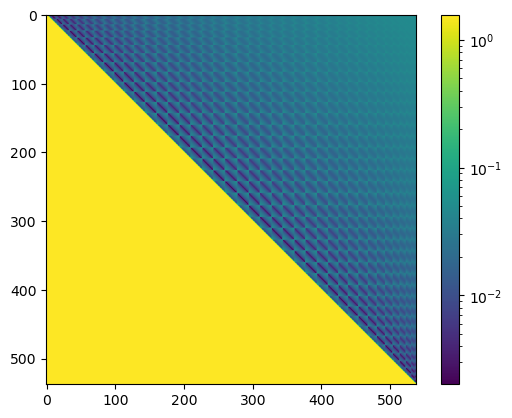

In [ ]:
vec = hp.ang2vec(theta_center[0], phi_center[0])
patch_inds = hp.query_disc(nside, vec=vec, radius=np.radians(radius_patch))
pix_inds = np.intersect1d(patch_inds, map_inds)
ra, dec = pixel2RaDec(pix_inds, nside)
cos_vartheta = np.cos(np.subtract.outer(ra, ra))*np.multiply.outer(np.cos(dec),np.cos(dec)) + np.multiply.outer(np.sin(dec),np.sin(dec))
dist = np.arccos(np.triu(cos_vartheta, k=1))
plt.imshow(dist, norm='log')
plt.colorbar()
distvec = []
relinds = []
for i in range(nbins):
    inds = np.where((dist > binedges[i]) & (dist < binedges[i+1]))
    distvec.append(dist[inds])
    relinds.append(inds)
distvec = np.concatenate(distvec)
relinds = np.concatenate(relinds, axis=1)
dec1 = dec[relinds[0]]
dec2 = dec[relinds[1]]
ra1 = ra[relinds[0]]
ra2 = ra[relinds[1]]

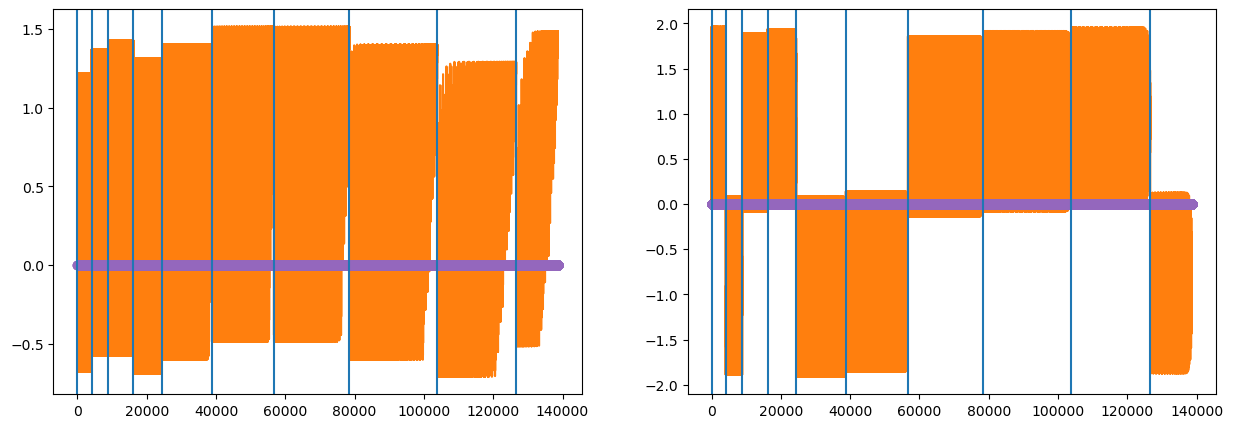

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
newbins = np.append([0], np.cumsum(bins[0]))
ax[0].plot(cos2phi_1[0]-cos2phi_2[0])
ax[0].plot(cos2phi_1[0]-corr.pair_cos_sin_2phi_1[0][0])
ax[1].plot(sin2phi_1[0]-sin2phi_2[0])
ax[1].plot(sin2phi_1[0]+corr.pair_cos_sin_2phi_1[0][1])
ax[0].plot(distvec/40, alpha=.6)
ax[1].plot(distvec/40, alpha=.6)
ax[0].plot(dec2/100)
ax[0].plot(dec1/100, 'o')
ax[1].plot(dec2/100)
ax[1].plot(dec1/100, 'o')
for i in range(nbins):
    ax[0].axvline(newbins[i])
    ax[1].axvline(newbins[i])

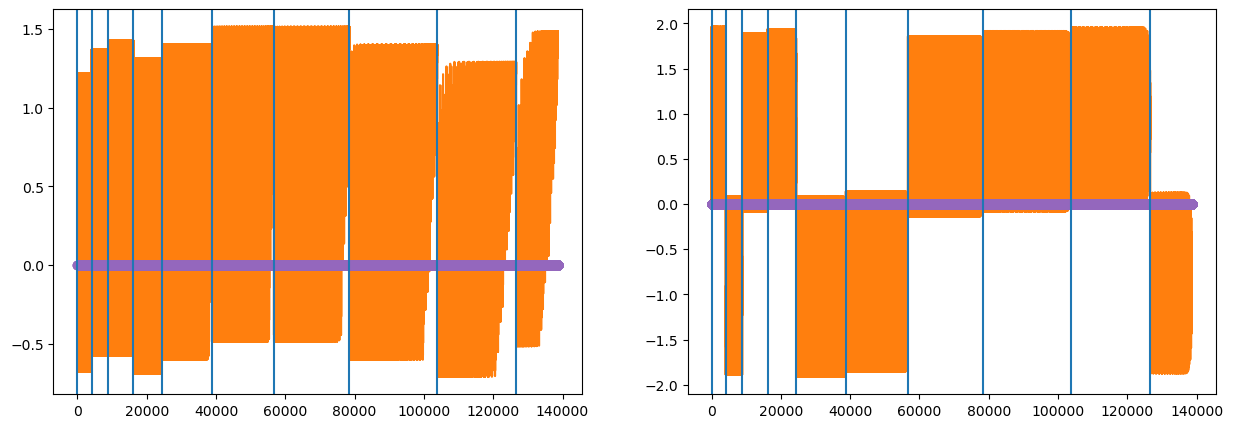

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
newbins = np.append([0], np.cumsum(bins[0]))

ax[0].plot(corr.pair_cos_sin_2phi_1[0][0]-corr.pair_cos_sin_2phi_2[0][0])
ax[0].plot(cos2phi_1[0]-corr.pair_cos_sin_2phi_1[0][0])

ax[1].plot(corr.pair_cos_sin_2phi_1[0][1]-corr.pair_cos_sin_2phi_2[0][1])
ax[1].plot(sin2phi_1[0]+corr.pair_cos_sin_2phi_1[0][1])

ax[0].plot(distvec/40, alpha=.6)
ax[1].plot(distvec/40, alpha=.6)
ax[0].plot(dec2/100)
ax[0].plot(dec1/100, 'o')
ax[1].plot(dec2/100)
ax[1].plot(dec1/100, 'o')
for i in range(nbins):
    ax[0].axvline(newbins[i])
    ax[1].axvline(newbins[i])

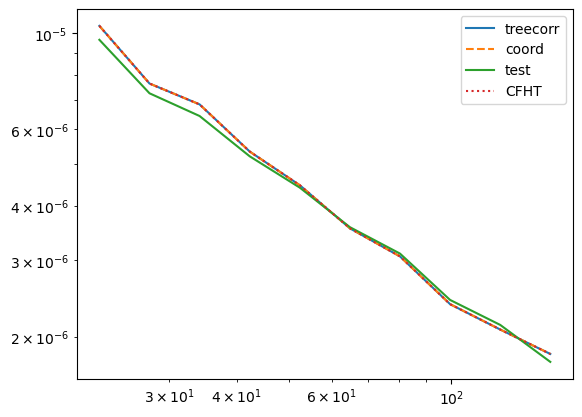

In [ ]:
plt.loglog(rnom, xip_coord.mean(axis=0), label="treecorr")
plt.loglog(rnom, xip_treecorr.mean(axis=0), label="coord", ls='--')
plt.loglog(rnom, xip_test.mean(axis=0), label="test")
plt.loglog(rnom, xip.mean(axis=0), label="CFHT", ls='dotted')
plt.legend()

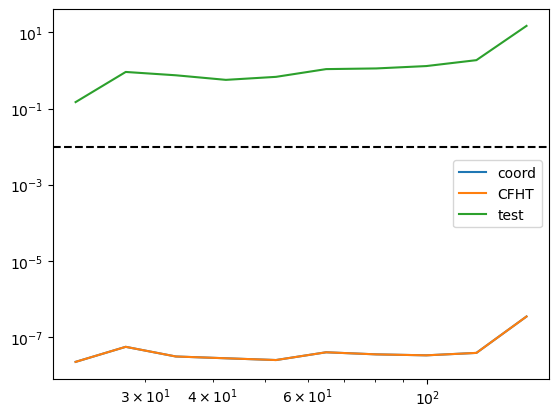

In [ ]:
plt.loglog(rnom, np.abs(1-(xip_coord/xip_treecorr)).mean(axis=0), label="coord")
plt.loglog(rnom, np.abs(1-(xip/xip_treecorr)).mean(axis=0), label="CFHT")
plt.loglog(rnom, np.abs(1-(xip_corr/xip_treecorr)).mean(axis=0), label="test")
plt.axhline(0.01, ls='--', c='k')

plt.legend()

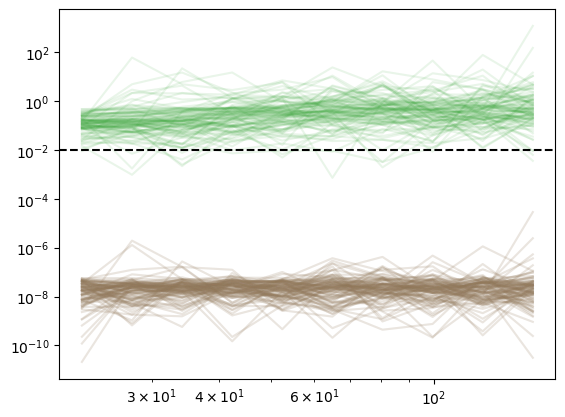

In [ ]:
for i in range(n_patches):
    plt.loglog(rnom, np.abs(1-(xip_coord/xip_treecorr))[i], label="coord", c='C0', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xip_corr/xip_treecorr))[i], label="test", c='C2', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xip/xip_treecorr))[i], label="CFHT", c='C1', alpha=.1)
plt.axhline(0.01, ls='--', c='k')
#plt.legend()

In [ ]:
for i in range(n_patches):
    plt.loglog(rnom, np.abs(1-(xim_coord/xim_treecorr))[i], label="coord", c='C0', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xim_corr/xim_treecorr))[i], label="test", c='C2', alpha=.1)
    plt.loglog(rnom, np.abs(1-(xim/xim_treecorr))[i], label="CFHT", c='C1', alpha=.1)
plt.axhline(0.01, ls='--', c='k')
#plt.legend()

In [ ]:
corr.pair_exp2phi[0].shape

(2, 138661)

In [ ]:
bins[0], corr.bins[0]

(array([ 4096,  4753,  7315,  8299, 14299, 17911, 21810, 25394, 22748,
        12036]),
 array([ 4096,  4753,  7315,  8299, 14299, 17911, 21810, 25394, 22748,
        12036]))